In [1]:
import torch
import torchvision
import torchvision.transforms as t
import torch.utils.data as data
import torch.nn.functional as f
from PIL import Image
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split

import os
import random
from tqdm import tqdm


/Users/parsahafezi/Workspace/DermaQ/DermaQEnv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [24]:
image_dir_path = "/Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/training_data_dermaq"
#device = torch.device('mps') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('mps')
device

device(type='mps')

In [3]:
trans_total = t.Compose([
    t.Resize(384, interpolation=t.InterpolationMode.BILINEAR),
    t.CenterCrop(384),
    t.ToTensor(),
    t.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
total_train_data  = torchvision.datasets.ImageFolder(root = image_dir_path, transform = trans_total)

In [6]:
class_names = total_train_data.classes
num_classes = len(class_names)

# Initialize a NumPy array to keep track of counts
class_counts = np.zeros(num_classes, dtype=int)

# Iterate through each class
for i, class_name in enumerate(class_names):
    class_folder_path = os.path.join(image_dir_path, class_name)

    # Check if the path is a directory
    if os.path.isdir(class_folder_path):

        # Get the list of files with a specific extension (e.g., '.jpg')
        files_in_class = [file for file in os.listdir(class_folder_path) if file.endswith('.jpg') or file.endswith('.JPEG') or file.endswith('.jpeg') ]

        # Get the count of files in the class folder
        file_count = len(files_in_class)

        # Update the class counts array
        class_counts[i] = file_count

# Calculate frequencies for each class
print(class_counts)

[ 327  514  485 1099  115 1113 6705 5000  142]


In [7]:
class_names

['akiec', 'bcc', 'benign', 'bkl', 'df', 'mel', 'nv', 'other', 'vasc']

In [8]:
sum(class_counts)

15500

In [9]:
weights = 15500 / (9 * class_counts)
print(weights)

[ 5.26673462  3.35062689  3.55097365  1.56708118 14.97584541  1.54736947
  0.25685641  0.34444444 12.12832551]


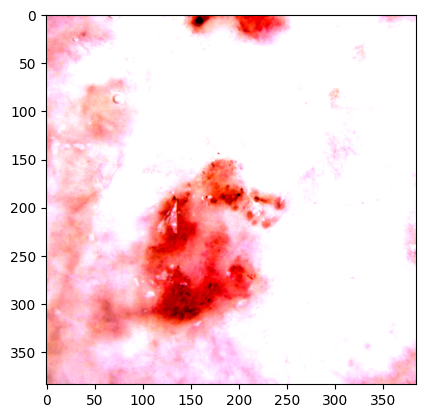

In [10]:
import matplotlib.pyplot as plt
import numpy as np

sample = total_train_data[0]  # Change the index as needed

# Extract the image tensor and label from the tuple
image_tensor, label = sample[0], sample[1]

# Convert the PyTorch tensor to a NumPy array
image_array = image_tensor.permute(1, 2, 0).numpy()

# Clip values to the valid range [0, 1] in case they are outside that range
image_array = np.clip(image_array, 0, 1)

# Display the image using matplotlib
plt.imshow(image_array)
plt.show()

In [11]:
# Stratified Sampling for train and val
train_idx, validation_idx = train_test_split(np.arange(len(total_train_data)),
                                             test_size=0.2,
                                             random_state=999,
                                             shuffle=True,
                                             stratify=total_train_data.targets)

# Subset dataset for train and val
train_dataset = data.Subset(total_train_data, train_idx)
valid_dataset = data.Subset(total_train_data, validation_idx)

# Dataloader for train and val
train_loader = data.DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = data.DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [12]:
model = torchvision.models.efficientnet_v2_s(weights='IMAGENET1K_V1')

In [13]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [14]:
model.classifier = torch.nn.Sequential(
                        torch.nn.Dropout(p=0.2, inplace=True),
                        torch.nn.Linear(1280, 9)
                    )

In [15]:
torch.save(model, "/Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/intial.pt")

In [16]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [17]:
class Trainer(object):

    def __init__(self, model, criterion, optimizer, max_epoch):
        """
            model: nn model
            criterion: loss function
            optimizer: optimizer
            max_epoch: maximum training epoch
        """
        self.model = model.to(device)
        self.criterion = criterion.to(device)
        self.optimizer = optimizer
        self.max_epoch = max_epoch

    def run(self,train_loader, valid_loader):
        """
            Main entry
                train_loader: training dataset, each item is (img, label)
                valid_loader: validation dataset, each item is (img, label)
        """
        # calculate the inital loss and accu on validation set
        valid_best_loss = self.validate(-1, valid_loader, best_loss=None)
        for epoch in range(self.max_epoch):
            self.train(epoch, train_loader)
            # save the checkpoint with the lowest validation loss
            valid_best_loss = self.validate(epoch, valid_loader, valid_best_loss)

    def train(self, epoch, loader):
        """
            Single training loop
                epoch: int, current epoch index
                loader: training loader
        """
        # switch to the train mode, calculate the gradient
        self.model.train()
        running_loss, total, correct = 0.0, 0, 0
        with tqdm(enumerate(loader, 0), mininterval=10) as tepoch:
            for i, data in tepoch:
                # get the inputs; data is a list of [inputs, labels]
                # inputs: tensor, (batch_size, image_size, image_size)
                # labels: tensor, (batch_size, 1)
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                ########################################################
                # TODO: replace the outputs and loss and update optimizer
                # 1. zero the parameter gradients
                # 2. forward + backward
                # 3. update the parameters
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                ########################################################

                # calculate the metric
                match, number = self.cal_metric(outputs.data, labels)

                # gather statistics
                total += number
                correct += match
                running_loss += loss.item()
                tepoch.set_postfix(loss=loss.item(), accuracy=100. * correct / total)

        running_loss /= len(loader)
        torch.save(self.model, '/Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_checkpoint.pt')
        print('Training | Epoch: {}| Loss: {:.3f} | Accuracy on train images: {:.1f}'.format \
              (epoch+1, running_loss, 100 * correct / total))

    def validate(self, epoch, loader, best_loss=None):
        """
            Single evaluation loop
                epoch: int, current epoch index
                loader: validation loader
                best_loss: float, current best loss
        """
        # switch to the evaluation mode, do not need to calculate the gradient
        self.model.eval()
        running_loss, total, correct = 0.0, 0, 0
        for i, data in tqdm(enumerate(loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            ########################################################
            # TODO: replace the outputs and loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            ########################################################

            # calculate the metric
            match, number = self.cal_metric(outputs.data, labels)

            # gather statistics
            total += number
            correct += match
            running_loss += loss.item()

        running_loss /= len(loader)

        save_file = '/Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_epoch{}_loss{:.2f}_accu{:.2f}.pt'.format(epoch+1, running_loss, 100 * correct / total)
        print('Save to file: ', save_file)
        torch.save(self.model, save_file)

        if best_loss is None or running_loss < best_loss:
            # if a better loss appears, save the checkpoin

            # overwrite the best_checkpoint.pt file
            torch.save(self.model, '/Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_checkpoint.pt')

            best_loss = running_loss

        print('Validation | Epoch: {}| Loss: {:.3f} | Accuracy on val images: {:.1f}'.format \
        (epoch+1, running_loss,100 * correct / total))

        return best_loss


    def cal_metric(self, outputs, labels):
        """
            Calculate the accuracy
                outputs: tensor (batch_size, number_class), the output of the model
                labels: tensor (batch_size, 1), the ground truth
        """
        # compare predictions to ground truth
        _, predicted = torch.max(outputs, 1)
        number = labels.size(0)
        correct = (predicted == labels).sum().item()
        return correct, number



In [18]:
NUM_EPOCH = 15
LEARNING_RATE = 0.001

criterion = torch.nn.CrossEntropyLoss(weight= torch.tensor(weights, dtype=torch.float32))
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
#optimizer = optim.Adagrad(model.parameters(), lr=LEARNING_RATE)
trainer = Trainer(model, criterion, optimizer, max_epoch=NUM_EPOCH)

In [19]:
trainer.run(train_loader, valid_loader)

3100it [02:08, 24.04it/s]


Save to file:  /Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_epoch0_loss2.28_accu5.45.pt
Validation | Epoch: 0| Loss: 2.277 | Accuracy on val images: 5.5


3100it [12:59,  3.98it/s, accuracy=74.7, loss=1.49]   


Training | Epoch: 1| Loss: 0.988 | Accuracy on train images: 74.7


3100it [02:09, 23.96it/s]


Save to file:  /Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_epoch1_loss0.57_accu79.23.pt
Validation | Epoch: 1| Loss: 0.568 | Accuracy on val images: 79.2


3100it [12:56,  3.99it/s, accuracy=82.2, loss=0.511]  


Training | Epoch: 2| Loss: 0.663 | Accuracy on train images: 82.2


3100it [02:09, 23.99it/s]


Save to file:  /Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_epoch2_loss0.49_accu84.29.pt
Validation | Epoch: 2| Loss: 0.489 | Accuracy on val images: 84.3


3100it [12:53,  4.01it/s, accuracy=84.8, loss=0.465]  


Training | Epoch: 3| Loss: 0.539 | Accuracy on train images: 84.8


3100it [02:08, 24.08it/s]


Save to file:  /Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_epoch3_loss0.47_accu86.48.pt
Validation | Epoch: 3| Loss: 0.469 | Accuracy on val images: 86.5


3100it [12:51,  4.02it/s, accuracy=86.7, loss=0.463]   


Training | Epoch: 4| Loss: 0.449 | Accuracy on train images: 86.7


3100it [02:08, 24.05it/s]


Save to file:  /Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_epoch4_loss4.91_accu77.65.pt
Validation | Epoch: 4| Loss: 4.911 | Accuracy on val images: 77.6


3100it [12:53,  4.01it/s, accuracy=88.9, loss=0.0313]  


Training | Epoch: 5| Loss: 0.368 | Accuracy on train images: 88.9


3100it [02:09, 23.91it/s]


Save to file:  /Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_epoch5_loss0.75_accu83.74.pt
Validation | Epoch: 5| Loss: 0.745 | Accuracy on val images: 83.7


3100it [12:52,  4.01it/s, accuracy=91, loss=0.0312]    


Training | Epoch: 6| Loss: 0.277 | Accuracy on train images: 91.0


3100it [02:09, 24.03it/s]


Save to file:  /Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_epoch6_loss0.42_accu87.32.pt
Validation | Epoch: 6| Loss: 0.421 | Accuracy on val images: 87.3


3100it [12:54,  4.00it/s, accuracy=91.4, loss=0.187]   


Training | Epoch: 7| Loss: 0.252 | Accuracy on train images: 91.4


3100it [02:08, 24.20it/s]


Save to file:  /Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_epoch7_loss0.55_accu81.74.pt
Validation | Epoch: 7| Loss: 0.554 | Accuracy on val images: 81.7


3100it [12:53,  4.01it/s, accuracy=92.6, loss=0.0711]  


Training | Epoch: 8| Loss: 0.231 | Accuracy on train images: 92.6


3100it [02:09, 23.93it/s]


Save to file:  /Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_epoch8_loss0.42_accu86.81.pt
Validation | Epoch: 8| Loss: 0.417 | Accuracy on val images: 86.8


3100it [12:53,  4.01it/s, accuracy=93.1, loss=0.522]   


Training | Epoch: 9| Loss: 0.198 | Accuracy on train images: 93.1


3100it [02:09, 23.89it/s]


Save to file:  /Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_epoch9_loss0.51_accu84.55.pt
Validation | Epoch: 9| Loss: 0.508 | Accuracy on val images: 84.5


3100it [12:51,  4.02it/s, accuracy=94.8, loss=0.0132]  


Training | Epoch: 10| Loss: 0.155 | Accuracy on train images: 94.8


3100it [02:09, 23.95it/s]


Save to file:  /Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_epoch10_loss0.69_accu80.68.pt
Validation | Epoch: 10| Loss: 0.694 | Accuracy on val images: 80.7


3100it [12:54,  4.00it/s, accuracy=95.5, loss=0.00887] 


Training | Epoch: 11| Loss: 0.123 | Accuracy on train images: 95.5


3100it [02:08, 24.07it/s]


Save to file:  /Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_epoch11_loss0.37_accu88.23.pt
Validation | Epoch: 11| Loss: 0.370 | Accuracy on val images: 88.2


3100it [12:53,  4.01it/s, accuracy=95.4, loss=0.0819]  


Training | Epoch: 12| Loss: 0.136 | Accuracy on train images: 95.4


3100it [02:08, 24.03it/s]


Save to file:  /Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_epoch12_loss0.38_accu88.74.pt
Validation | Epoch: 12| Loss: 0.380 | Accuracy on val images: 88.7


3100it [12:54,  4.00it/s, accuracy=96.9, loss=0.00189] 


Training | Epoch: 13| Loss: 0.092 | Accuracy on train images: 96.9


3100it [02:09, 23.95it/s]


Save to file:  /Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_epoch13_loss0.35_accu90.16.pt
Validation | Epoch: 13| Loss: 0.349 | Accuracy on val images: 90.2


3100it [13:00,  3.97it/s, accuracy=97.7, loss=0.0257]  


Training | Epoch: 14| Loss: 0.064 | Accuracy on train images: 97.7


3100it [02:13, 23.23it/s]


Save to file:  /Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_epoch14_loss0.41_accu88.45.pt
Validation | Epoch: 14| Loss: 0.407 | Accuracy on val images: 88.5


3100it [13:03,  3.95it/s, accuracy=97.5, loss=0.141]   


Training | Epoch: 15| Loss: 0.072 | Accuracy on train images: 97.5


3100it [02:09, 23.95it/s]


Save to file:  /Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_epoch15_loss11.35_accu89.52.pt
Validation | Epoch: 15| Loss: 11.353 | Accuracy on val images: 89.5


In [25]:
best_model = torch.load("/Users/parsahafezi/Workspace/DermaQ/Skin-Oracle/vision/model_checkpoints/best_model.pt")
best_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(model, valid_loader):
    # Set the model to evaluation mode
    model.eval()
    
    # Lists to store predictions and ground truth labels
    all_predictions = []
    all_labels = []
    
    # Iterate through the validation loader
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass to get predictions
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Convert predictions and labels to numpy arrays
            predicted = predicted.cpu().numpy()
            labels = labels.cpu().numpy()
            
            # Append predictions and labels to the lists
            all_predictions.extend(predicted)
            all_labels.extend(labels)
    
    # Compute precision, recall, and F1 score
    pre_val = precision_score(all_labels, all_predictions, average='weighted')
    rec_val = recall_score(all_labels, all_predictions, average='weighted')
    f1_val = f1_score(all_labels, all_predictions, average='weighted')
    
    return pre_val, rec_val, f1_val

# Example usage
# Assuming model and valid_loader are already defined
pre_val, rec_val, f1_val = calculate_metrics(best_model, valid_loader)

print("Precision:", pre_val)
print("Recall:", rec_val)
print("F1 Score:", f1_val)

Precision: 0.9010650668830856
Recall: 0.9016129032258065
F1 Score: 0.8978480924637885
